In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import tensorflow as tf
import os
import PIL
import pathlib

# Creating Train and Validation tf.data.datasets

In [14]:
df = pd.read_csv('./dataset/train.csv')
df['Id'] = './dataset/train/' + df['Id'] + '.jpg'

In [15]:
TRAIN_VAL_SPLIT_INDEX = int(0.9 * df.shape[0])
df = df.sample(frac=1.0)
train_df = df.iloc[ : int(0.3*TRAIN_VAL_SPLIT_INDEX)]
val_df = df.iloc[TRAIN_VAL_SPLIT_INDEX : ]

In [16]:
train_img_names = train_df.pop('Id').to_numpy()
train_targets = train_df.pop('Pawpularity').to_numpy()

val_img_names = val_df.pop('Id').to_numpy()
val_targets = val_df.pop('Pawpularity').to_numpy()

In [31]:
IMG_SIZE = 224
BATCH_SIZE = 32

def parse_image_file(img_name):
    image = tf.io.read_file(img_name)
    image = tf.io.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image

train_dataset = tf.data.Dataset.from_tensor_slices(( train_img_names, train_targets ))
train_dataset = train_dataset.map(lambda image,label: (parse_image_file(image), label)).shuffle(100).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices(( val_img_names, val_targets ))
val_dataset = val_dataset.map(lambda image,label: (parse_image_file(image), label)).shuffle(100).batch(BATCH_SIZE)

# Loading EfficientNet and rebuilding top layers

In [32]:
img_augmentation = tf.keras.models.Sequential(
    [
        tf.keras.layers.RandomRotation(factor=1/32),
        tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

def build_model():
    inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    mobilenet = tf.keras.applications.MobileNetV3Small(include_top=False, weights="imagenet")

    # Freeze the pretrained weights
    mobilenet.trainable = False

    # Rebuild top
    x = mobilenet(x)
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    x = tf.keras.layers.Dense(64, activation="relu", name="features")(x)
    outputs = tf.keras.layers.Dense(1, activation="relu", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="mean_squared_error"
    )
    return model


# Model Training

In [33]:
# with strategy.scope():
model = build_model()

epochs = 2  # @param {type: "slider", min:1, max:8}
hist = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

6709248/6698480 [==============================] - 1s 0us/step
Epoch 1/2
84/84 [==============================] - 81s 917ms/step - loss: 578.7298 - val_loss: 493.3423
Epoch 2/2
84/84 [==============================] - 85s 995ms/step - loss: 457.6443 - val_loss: 479.7150


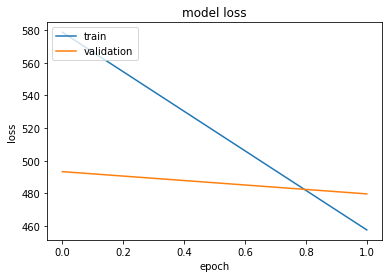

In [34]:
def plot_hist(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(hist)

# Building and predicting on Test set

In [35]:
test_df = pd.read_csv('./dataset/test.csv')
test_img_ids = test_df['Id'].copy()
test_df['Id'] = './dataset/test/' + test_df['Id'] + '.jpg'
test_img_names = test_df.pop('Id').to_numpy()

test_dataset = tf.data.Dataset.from_tensor_slices(test_img_names)
test_dataset = test_dataset.map(parse_image_file).batch(BATCH_SIZE)

In [36]:
predictions = model.predict(test_dataset)

In [37]:
final = pd.DataFrame()
final['Id'] = test_img_ids
final['Pawpularity'] = predictions
final.to_csv('submission.csv', index=False)

final.head(3)

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,42.748055
1,43a2262d7738e3d420d453815151079e,42.764221
2,4e429cead1848a298432a0acad014c9d,42.762508
